In [1]:
#Importing packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
import time
from operator import itemgetter

In [2]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny_auto_threshold(img,sigma=0.3):
    # median gray channel intensity
    #plt.imshow(image)
    x_center = image.shape[1]/2

    crop_y_t = 560
    crop_y_l = 660
    crop_x_r = x_center+350
    crop_x_l = x_center-350

    crop_img = image[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
    
    
    # calculate low and high threshold
    high_threshold = min(255, crop_img.max())   
    low_threshold = max(0, high_threshold - (crop_img.mean()*sigma))
    
    return (low_threshold, high_threshold)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines,color=[255, 0, 0], thickness=2):
    #initialization
    
    #array initialization
    rt_lane_slopes = []
    lf_lane_slopes = []
    
    #var initialization
    rt_lines_pos = []
    lf_lines_pos = []
    
    for line in lines:
        for x1,y1,x2,y2 in line: 
            
            #remove
            cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)
            
            pi = np.pi
            m = ((y2-y1)/(x2-x1))
            m_angle = np.arctan(m)
            x_center = image.shape[1]/2
            
            #right lane
            if m > 0.50 and m < 0.90 and x1>(x_center+50):
                #append slope values
                rt_lane_slopes.append(m)
                #append line positions
                rt_lines_pos.append((x1,y1))
                
            elif m < -0.60 and m > -0.90 and x2<(x_center-50):
                #append slope values
                lf_lane_slopes.append(m)
                #append line positions
                lf_lines_pos.append((x2,y2))       
    
    #drawing right lane

    #filter points to stay within standard deviation threshold
    rt_lane_slopes = np.array(rt_lane_slopes)
    
    #average slopes
    rt_slope_avg = np.array(rt_lane_slopes).mean()
    
    #determine right lane position
    rt_lines_pos = sorted(rt_lines_pos, key=itemgetter(0))
    rt_lane_pos = rt_lines_pos[int(math.floor(len(rt_lines_pos)/2))]
    rt_top = rt_lines_pos[0]
    
    #set x/y position for right lane upper end
    rt_top_x = rt_top[0]
    rt_top_y = rt_top[1]
    
    rt_lw_y = image.shape[0]
    
    #calculate x position for right lane lower end
    rt_lw_x = int(math.floor(((rt_lw_y - rt_top_y) / rt_slope_avg + rt_top_x)))
    
    cv2.line(img, (rt_lw_x, image.shape[0]), (rt_top_x, rt_top_y), color, thickness)
    
    #drawing left lane
    
    #filter points to stay within standard deviation threshold
    lf_lane_slopes = np.array(lf_lane_slopes)
    
    #average slopes
    lf_slope_avg = np.array(lf_lane_slopes).mean()    

    #determine left lane position
    lf_lines_pos = sorted(lf_lines_pos, key=itemgetter(0))    
    lf_lane_pos = lf_lines_pos[int(math.floor(len(lf_lines_pos)/2))]
    lf_top = lf_lines_pos[int(len(lf_lines_pos)-1)]
    
    #set x/y position for left lane upper end
    lf_top_x = lf_top[0]
    lf_top_y = lf_top[1]
 
    lf_lw_y = image.shape[0]
    
    #calculate x position for left lane lower end
    lf_lw_x = int(math.floor((lf_lw_y - lf_top_y) / lf_slope_avg + lf_top_x))
    
    cv2.line(img, (lf_lw_x, image.shape[0]), (lf_top_x, lf_top_y), color, thickness)  

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def CLAHE_img(img,clipLimit, tileGridSize):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize)
    return clahe.apply(img)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


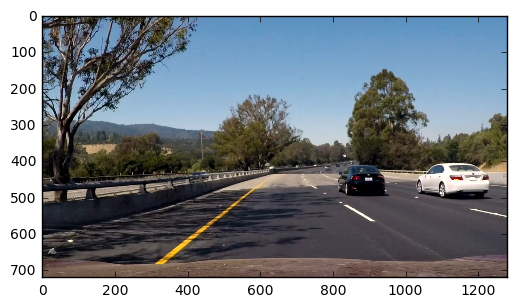

In [3]:
#reading in an image

#image = mpimg.imread('test_images/solidYellowCurve.jpg')
image = VideoFileClip('challenge.mp4').get_frame(3.6)

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

(100, 700, 3)


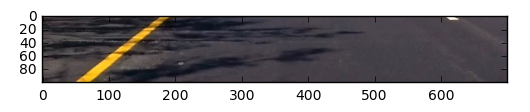

In [4]:
#test cell to remove
#plt.imshow(image)
x_center = image.shape[1]/2

crop_y_t = 560
crop_y_l = 660
crop_x_r = x_center+350
crop_x_l = x_center-350

#crop_y_t = 560
#crop_y_l = 660
#crop_x_r = x_center+500
#crop_x_l = x_center-500


crop_img = image[crop_y_t:crop_y_l,crop_x_l:crop_x_r]
plt.imshow(crop_img)
print(crop_img.shape)

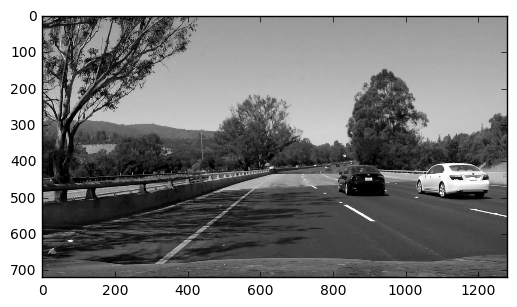

In [5]:
#reduce colored image to grayscaled image
image_grayed = grayscale(image)
plt.imshow(image_grayed, cmap='gray')

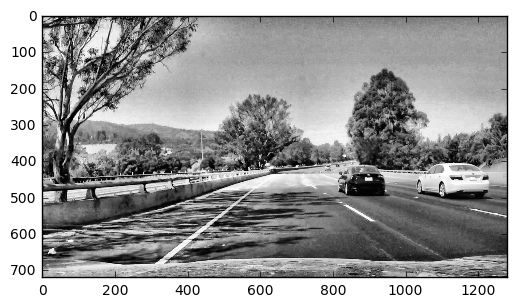

In [6]:
#apply CLAHE
image_clahe = CLAHE_img(image_grayed,4.0, (8,8))
plt.imshow(image_clahe, cmap='gray')

(235.45917714285713, 255)


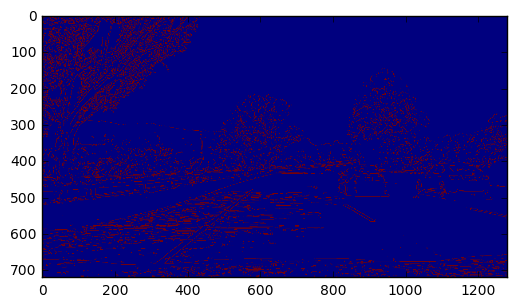

In [7]:
#apply canny to grayscaled image
canny_threshold = canny_auto_threshold(image_clahe)
image_canny = canny(image_clahe,canny_threshold[0],canny_threshold[1])
print(canny_threshold)
plt.imshow(image_canny)

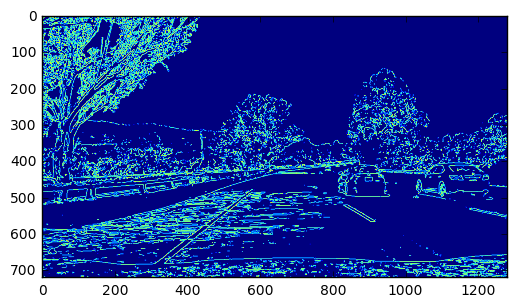

In [8]:
#apply gaussian blur to image
kernel_size = 3
image_gauss = gaussian_blur(image_canny,kernel_size)
plt.imshow(image_gauss)

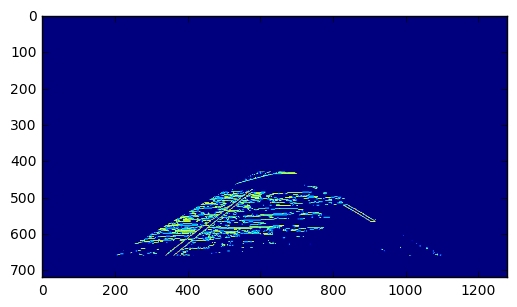

In [9]:
#pick area of interest
x_center = image.shape[1] / 2
top_left_v = (x_center-50,430)
low_left_v = (200,image.shape[0]-60)
top_right_v = (x_center+50,430)
low_right_v = (image.shape[1] - 150,image.shape[0]-60)
vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
image_mask = region_of_interest(image_gauss,vertices)
plt.imshow(image_mask)

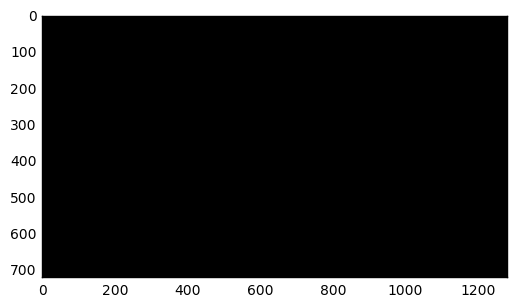

In [10]:
#determine hough lines
lines_hough = hough_lines(image_mask,0.5, np.pi/180, 30, 5, 5)
plt.imshow(lines_hough)

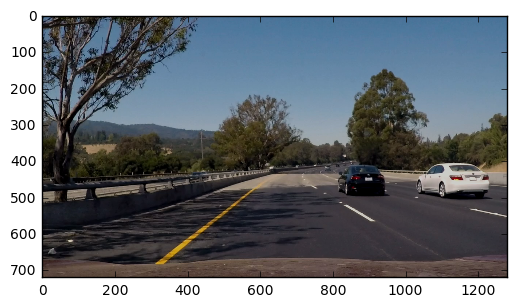

In [11]:
#Add weighed lines onto initial image
image_final = weighted_img(lines_hough,image)
plt.imshow(image_final)

In [12]:
def process_image(image):
    image_grayed = grayscale(image)
    image_clahe = CLAHE_img(image_grayed,4.0, (8,8))
    canny_threshold = canny_auto_threshold(image_clahe)
    image_canny = canny(image_clahe,canny_threshold[0],canny_threshold[1])
    kernel_size = 3
    image_gauss = gaussian_blur(image_canny,kernel_size)
    x_center = image.shape[1] / 2
    top_left_v = (x_center-50,430)
    low_left_v = (200,image.shape[0]-60)
    top_right_v = (x_center+50,430)
    low_right_v = (image.shape[1] - 150,image.shape[0]-60)
    vertices = np.array([[top_left_v,low_left_v,low_right_v,top_right_v]],dtype=np.int32)
    image_mask = region_of_interest(image_gauss,vertices)
    lines_hough = hough_lines(image_mask,0.5, np.pi/180, 30, 5, 5)
    image_final = weighted_img(lines_hough,image)
    plt.imshow(image_final)
        
    return image_final

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:29<00:00,  9.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 26.1 s, sys: 3.03 s, total: 29.1 s
Wall time: 31.4 s


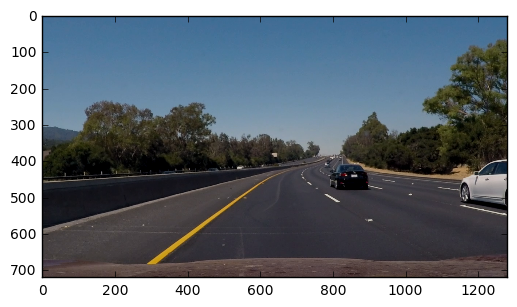

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)